## Import Libraries & Load Data

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np
import re

# Load the Likert responses CSV
df_likert = pd.read_csv("../data/likert_responses.csv")
df_likert.head()

,participant,question,original_column,phase,response
0,0,Are you currently enrolled in a university deg...,Are you currently enrolled in a university deg...,yes/no,No
1,1,Are you currently enrolled in a university deg...,Are you currently enrolled in a university deg...,yes/no,Yes
2,2,Are you currently enrolled in a university deg...,Are you currently enrolled in a university deg...,yes/no,Yes
3,3,Are you currently enrolled in a university deg...,Are you currently enrolled in a university deg...,yes/no,Yes
4,4,Are you currently enrolled in a university deg...,Are you currently enrolled in a university deg...,yes/no,Yes



--- I have felt cheerful and in good spirits ---
Before vs During: p = 0.0007
During vs After: p = 0.0108
Before vs After: p = 0.3739


C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


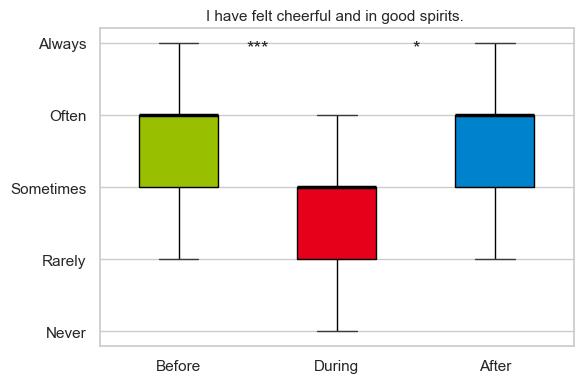

C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- In this phase, how often did you feel calm and relaxed? (Question identical to WHO-5 Well-Being Index) ---
Before vs During: p = 0.0091
During vs After: p = 0.1710
Before vs After: p = 0.1674


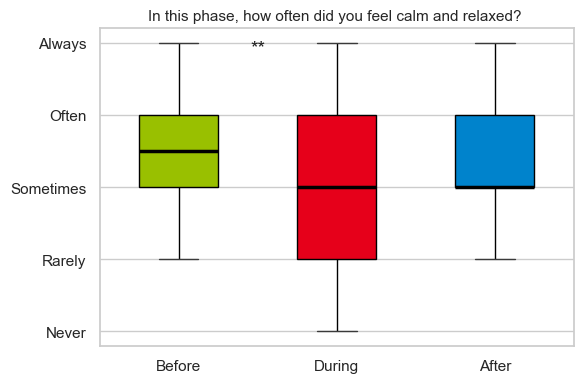

C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- I have felt active and vigorous ---
Before vs During: p = 0.0001
During vs After: p = 0.0000
Before vs After: p = 0.7269


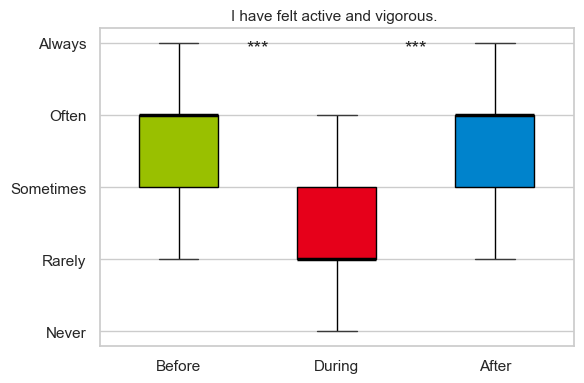

C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- I woke up feeling fresh and rested ---
Before vs During: p = 0.0004
During vs After: p = 0.0054
Before vs After: p = 0.3933


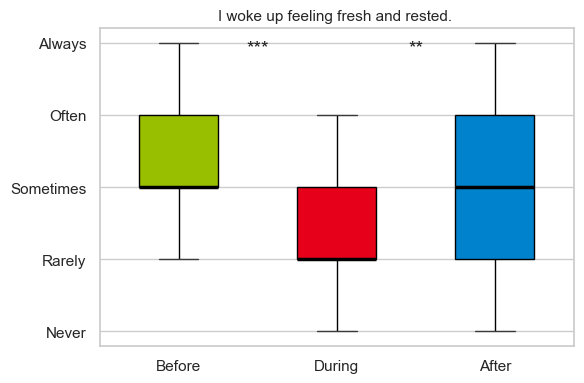

C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- My daily life has been filled with things that interest me ---
Before vs During: p = 0.0039
During vs After: p = 0.0737
Before vs After: p = 0.2596


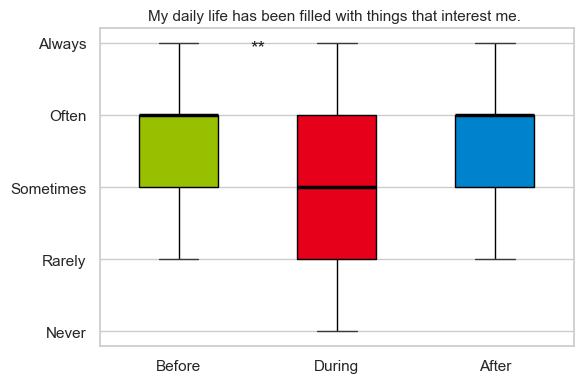

C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- I felt significantly anxious or stressed ---
Before vs During: p = 0.0036
During vs After: p = 0.0562
Before vs After: p = 0.3206


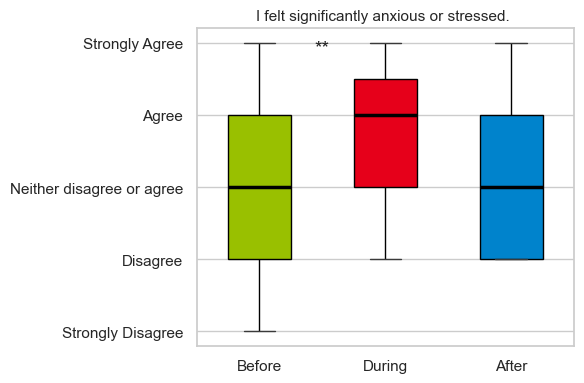

C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- I received sufficient mental well-being support from my university ---
Before vs During: p = 0.3730
During vs After: p = 0.6189
Before vs After: p = 0.6687


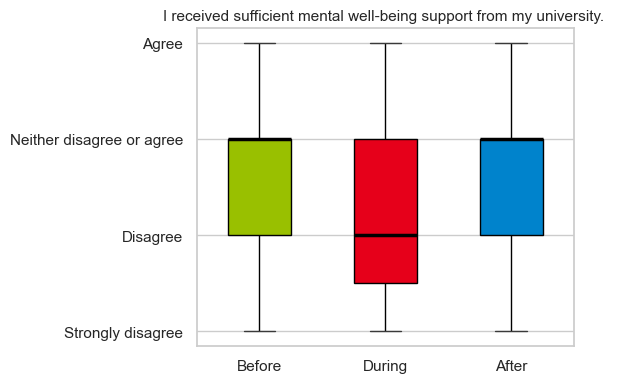

C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- How would you rate your academic productivity during this time? (Question adapted from Ralph et al ---
Before vs During: p = 0.0039
During vs After: p = 0.0008
Before vs After: p = 0.4724


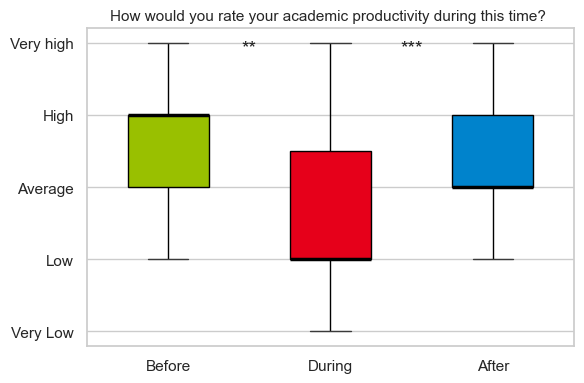

C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- How much was your academic workload on average? (Question adapted from Baticulon et al ---
Before vs During: p = 0.6228
During vs After: p = 0.6158
Before vs After: p = 0.9359


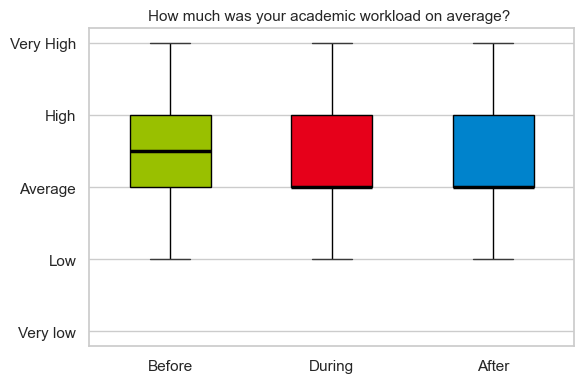

C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- Did you feel pressure to appear constantly available or responsive for academic obligations? (Question adapted from Ralph et al ---
Before vs During: p = 0.6042
During vs After: p = 0.1497
Before vs After: p = 0.2593


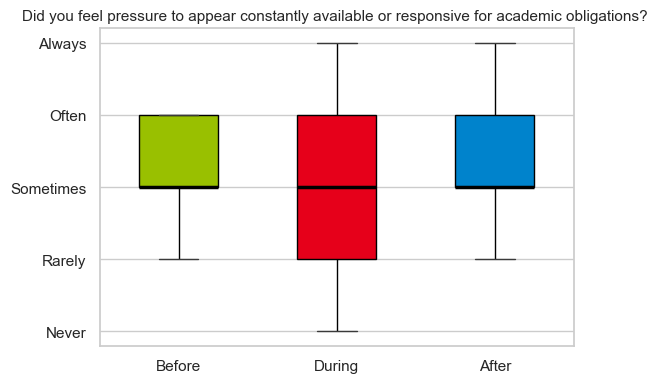

C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- Were you able to stay on top of your academic tasks during this time? (Question inspired by Ralph et al ---
Before vs During: p = 0.0074


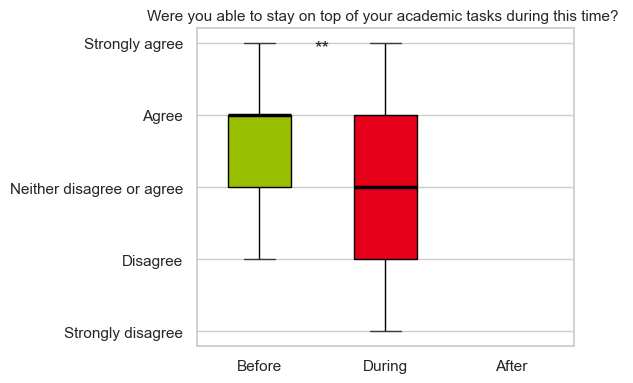

C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- How confident did you feel in the quality of your academic work? (Question adapted from Ralph et al ---
Before vs During: p = 0.0763
During vs After: p = 0.0633
Before vs After: p = 0.9337


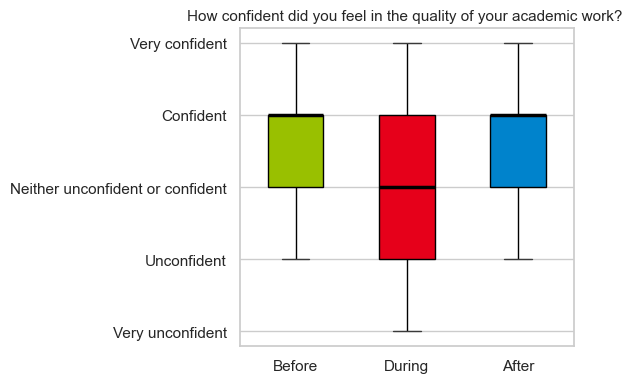

C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- Did you feel pressure to appear constantly online or available at work? (Question adapted from Ralph et al ---
Before vs During: p = 0.1025
During vs After: p = 0.1257
Before vs After: p = 0.9791


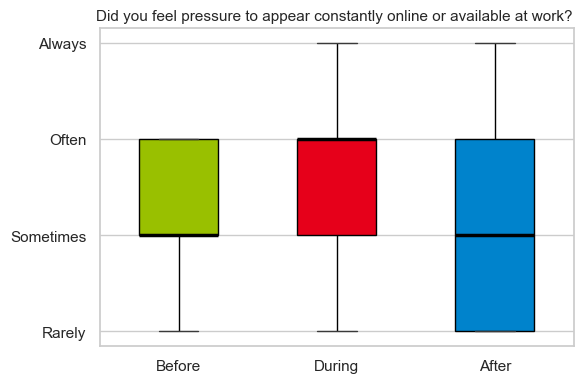

C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- How confident were you in the quality of your work-related output? (Question adapted from Ralph et al ---
Before vs During: p = 0.8950
During vs After: p = 0.5757
Before vs After: p = 0.5606


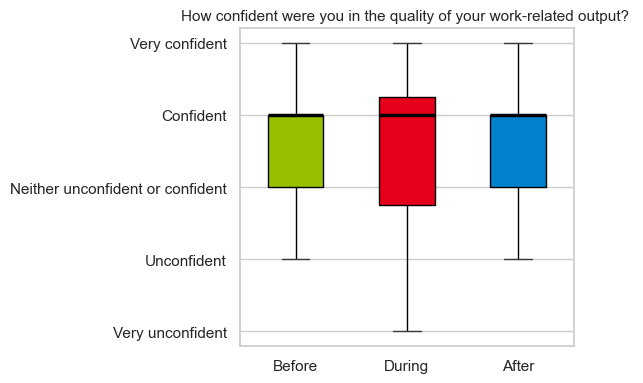

C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- How did you perceive the communication with peers or colleagues? (Question adapted from Siegel et al ---
Before vs During: p = 0.0012
During vs After: p = 0.0011
Before vs After: p = 0.9517


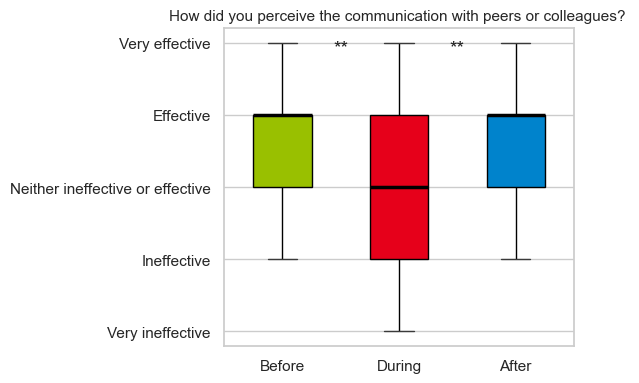

C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- Did you feel disconnected from your academic or work environment? (Question adapted from Hohne et al ---
Before vs During: p = 0.0000
During vs After: p = 0.0002
Before vs After: p = 0.4753


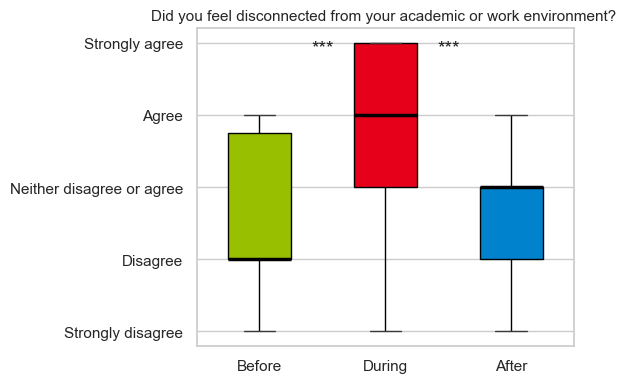

C:\Users\julia\AppData\Local\Temp\ipykernel_9256\951046485.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(



--- I feel that my practical computer science skills improved ---
Before vs During: p = 0.0093
During vs After: p = 0.0182
Before vs After: p = 0.7921


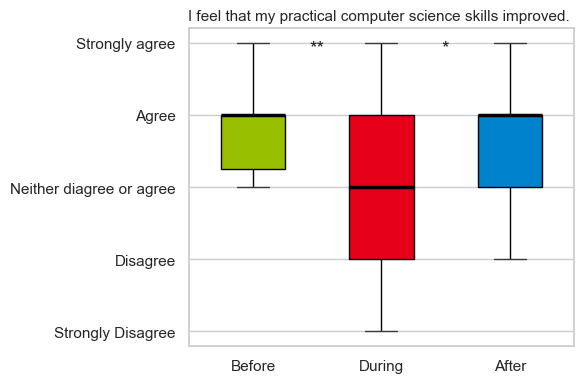

In [66]:
# === Colors and order
phase_colors = {
    "before": "#99C000",   # Green
    "during": "#E6001A",   # Red
    "after": "#0083CC"     # Blue
}
phase_order = ["before", "during", "after"]

# === Extract Likert mapping
def extract_numeric_mapping(responses):
    mapping = {}
    for resp in responses:
        match = re.match(r"(\d)\s*-\s*(.+)", str(resp))
        if match:
            num = int(match.group(1))
            label = match.group(2).strip()
            mapping[resp] = (num, label)
    return mapping if mapping else None

# === Build mappings per question
response_variants_by_question = df_likert.groupby("question")["response"].apply(list)
question_mappings = {}
for question, responses in response_variants_by_question.items():
    numeric_map = extract_numeric_mapping(responses)
    if numeric_map:
        question_mappings[question] = numeric_map

# === Add numeric score + label
df_mapped = df_likert.copy()
for question, mapping in question_mappings.items():
    mask = df_mapped["question"] == question
    df_mapped.loc[mask, "score"] = df_mapped.loc[mask, "response"].map(lambda x: mapping.get(x, (None, None))[0])
    df_mapped.loc[mask, "label"] = df_mapped.loc[mask, "response"].map(lambda x: mapping.get(x, (None, None))[1])
df_mapped = df_mapped.dropna(subset=["score"])
df_mapped["score"] = df_mapped["score"].astype(int)

# === Plot each question
sns.set(style="whitegrid")
for question in df_mapped["question"].unique():
    subset = df_mapped[df_mapped["question"] == question].copy()
    if subset["phase"].nunique() < 2:
        continue

    # Likert label mapping
    mapping = question_mappings.get(question, {})
    score_order = sorted({v[0] for v in mapping.values()})
    label_by_score = {v[0]: v[1] for v in mapping.values()}
    y_labels = [label_by_score[s] for s in score_order]

    # === Plot
    plt.figure(figsize=(6, 4))
    ax = sns.boxplot(
        data=subset,
        x="phase",
        y="score",
        order=phase_order,
        palette=phase_colors,
        width=0.5,
        showcaps=True,
        boxprops={"edgecolor": "black"},
        whiskerprops={"color": "black"},
        medianprops={"color": "black", "linewidth": 2.5},
        flierprops={'marker': ''},
        saturation=1.0,
    )
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Adjust Likert labels on y-axis
    plt.yticks(ticks=score_order, labels=y_labels)
    plt.xticks(ticks=[0, 1, 2], labels=["Before", "During", "After"])
    plt.title(question.split('(')[0], fontsize=11)

    # === Statistical tests: independent t-test across all responses (not per user)
    p_vals = {}
    comparisons = [("before", "during"), ("during", "after"), ("before", "after")]
    for a, b in comparisons:
        scores_a = subset[subset["phase"] == a]["score"]
        scores_b = subset[subset["phase"] == b]["score"]
        if len(scores_a) > 1 and len(scores_b) > 1:
            stat, p = ttest_ind(scores_a, scores_b, equal_var=False)
            p_vals[(a, b)] = p
        else:
            p_vals[(a, b)] = np.nan

    # === Asterisks on plot
    y_max = max(score_order) - 0.2
    x_coords = {"before": 0, "during": 1, "after": 2}
    for (a, b), p in p_vals.items():
        if pd.notna(p):
            star = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
            if star:
                x1, x2 = x_coords[a], x_coords[b]
                x_mid = (x1 + x2) / 2
                ax.text(x_mid, y_max, star, ha='center', va='bottom', fontsize=14)

    # === Print p-values
    print(f"\n--- {question.split('.')[0]} ---")
    for (a, b), p in p_vals.items():
        if pd.notna(p):
            print(f"{a.capitalize()} vs {b.capitalize()}: p = {p:.4f}")

    plt.tight_layout()
    plt.show()


## Plot for RQ 1 Poster

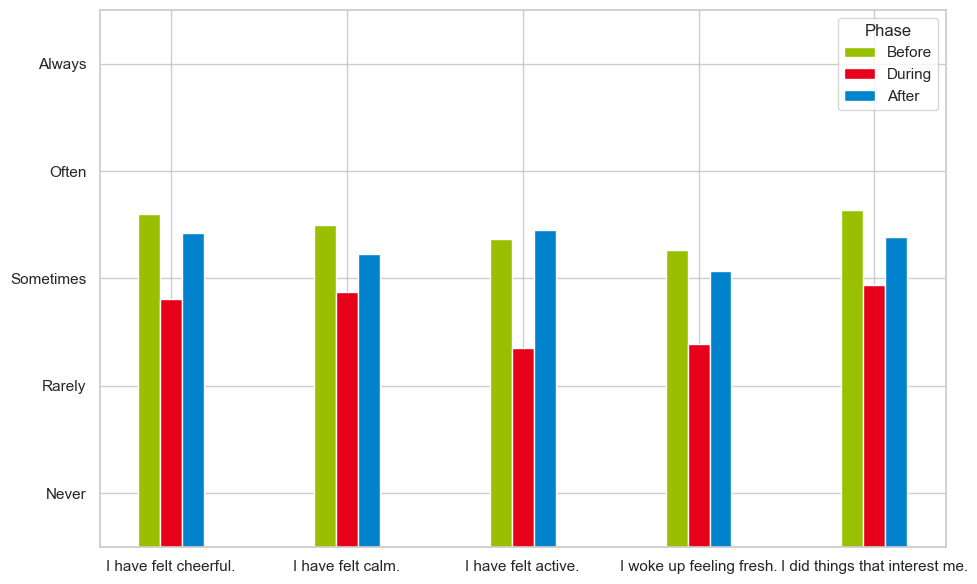

In [68]:
# === Label mappings
score_labels = {
    1: "Never", 2: "Rarely", 3: "Sometimes", 4: "Often", 5: "Always"
}

clean_labels = {
    "I have felt cheerful and in good spirits. (Question identical to WHO-5 Well-Being Index)": "I have felt cheerful.",
    "In this phase, how often did you feel calm and relaxed? (Question identical to WHO-5 Well-Being Index)": "I have felt calm.",
    "I have felt active and vigorous. (Question identical to WHO-5 Well-Being Index)": "I have felt active.",
    "I woke up feeling fresh and rested. (Question identical to WHO-5 Well-Being Index)": "I woke up feeling fresh.",
    "My daily life has been filled with things that interest me. (Question identical to WHO-5 Well-Being Index)": "I did things that interest me."
}

phase_order = ["before", "during", "after"]

# === Filter WHO-5 data
subset = df_mapped[df_mapped["question"].isin(clean_labels.keys())].copy()
subset["short_question"] = subset["question"].map(clean_labels)

# === Compute average scores
avg_df = (
    subset.groupby(["short_question", "phase"])["score"]
    .mean()
    .reset_index(name="avg_score")
)

# === Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
group_gap = 1

x_positions = []
x_labels = []
questions = list(clean_labels.values())

for i, question in enumerate(questions):
    for j, phase in enumerate(phase_order):
        row = avg_df[
            (avg_df["short_question"] == question) &
            (avg_df["phase"] == phase)
        ]
        if not row.empty:
            avg_score = row["avg_score"].values[0]
        else:
            avg_score = 0  # fallback

        xpos = i * (len(phase_order) * bar_width + group_gap) + j * bar_width
        x_positions.append(xpos)
        x_labels.append("")  # suppress individual phase names on x-axis
        ax.bar(
            xpos,
            avg_score,
            width=bar_width,
            color=phase_colors[phase],
            label=phase.capitalize() if i == 0 else None
        )

# === Styling
group_centers = [
    i * (len(phase_order) * bar_width + group_gap) + bar_width
    for i in range(len(questions))
]
ax.set_xticks(group_centers)
ax.set_xticklabels(questions, rotation=0, ha='center')

# ax.set_ylabel("Average Likert Score")
ax.set_ylim(0.5, 5.5)
ax.set_yticks(list(score_labels.keys()))
ax.set_yticklabels(score_labels.values())

# ax.set_title("WHO-5 Well-Being Items: Average Response by Phase")
ax.legend(title="Phase")
plt.tight_layout()
plt.show()